In [2]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler

from pyfrechet.metric_spaces import MetricData, Sphere, Euclidean
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metrics import mse

from geomstats.geometry.hypersphere import Hypersphere

INFO: Using numpy backend


In [4]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='jdf.csv'
jdf=pd.read_csv(path+file_name)
jdf['time']=pd.to_datetime(jdf['time'])
print(jdf.info())
print(jdf.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638400 entries, 0 to 638399
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   lat     638400 non-null  float64       
 1   lon     638400 non-null  float64       
 2   time    638400 non-null  datetime64[ns]
 3   theta   579220 non-null  float64       
 4   speed   579224 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 24.4 MB
None
         lat         lon       time     theta     speed
0  48.176060 -123.884422 2020-06-01 -3.132664  0.409679
1  48.176060 -123.905243 2020-06-01  3.115283  0.388374
2  48.176060 -123.926064 2020-06-01  3.132664  0.388014
3  48.176060 -123.946884 2020-06-01  3.023335  0.509690
4  48.194038 -123.801132 2020-06-01  3.008242  0.304657
count                           638400
mean     2021-06-15 22:29:59.999999744
min                2020-06-01 00:00:00
25%                2020-12-07 23:15:00
50%               

In [3]:
print(jdf.isna().sum())
jdf=jdf.dropna()
print((jdf.shape))

jdf_subsample=jdf.sample(n=1000, random_state=100)

min_date=jdf_subsample['time'].min()
max_date=jdf_subsample['time'].max()
jdf_subsample['time']=(jdf_subsample['time'] - min_date)/(max_date - min_date)
jdf_subsample['time']=jdf_subsample['time'].astype(float)
print(jdf_subsample.head())


lat          0
lon          0
time         0
theta    59180
speed    59176
dtype: int64
(579220, 5)
              lat         lon      time     theta     speed
600023  48.265960 -123.967700  0.940847 -2.081746  0.256206
383147  48.176060 -123.926064  0.600593  0.139582  0.643160
453556  48.283939 -123.905243  0.710990 -0.111270  0.604431
263714  48.283939 -123.863602  0.413083 -1.733195  0.601459
430231  48.265961 -123.821953  0.674411 -1.923787  0.417967


In [4]:
X=jdf_subsample[['lat', 'lon', 'speed', 'time']].values
M=Sphere(1)
y=MetricData(M, Hypersphere(dim=1).angle_to_extrinsic(jdf_subsample['theta'].values))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

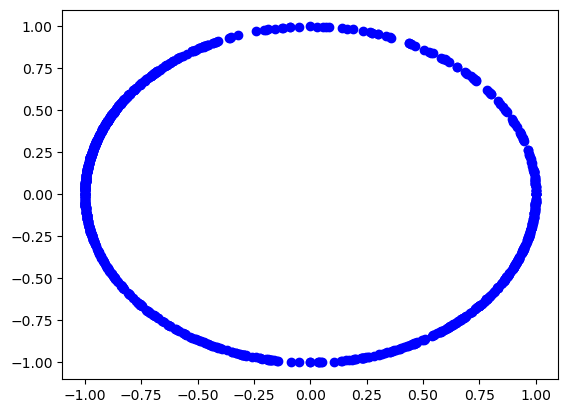

In [6]:
plt.figure()
plt.scatter(y.data[:,0], y.data[:,1], label='Reference', color='blue')
plt.show()

In [7]:
base = Tree(split_type='2means',
            impurity_method='medoid',
            mtry=2,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4,
                         verbose=1)
forest.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 34.7min finished


BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(impurity_method='medoid', mtry=2,
                               split_type='2means'),
                n_jobs=4, verbose=1)

In [10]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

MSE: 3.1692738107228746


In [11]:
forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 1.8404846861453075


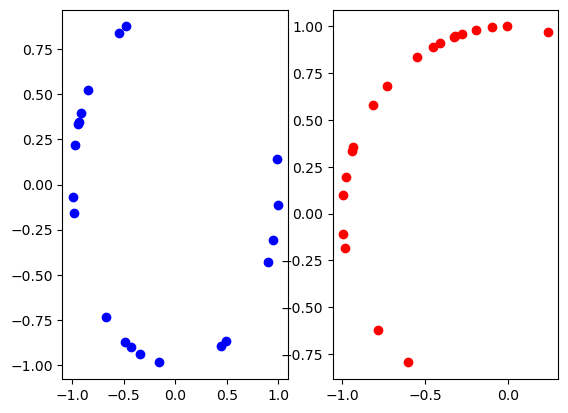

In [15]:
fig, axs=plt.subplots(1,2)
axs[0].scatter(y.data[:20,0], y.data[:20,1], label='Reference', color='blue')
axs[1].scatter(forest_predictions.data[:20,0], forest_predictions.data[:20,1], label='Predicted', color='red')
plt.show()

In [16]:
oob_errors=forest.oob_errors()

In [17]:
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

0.932

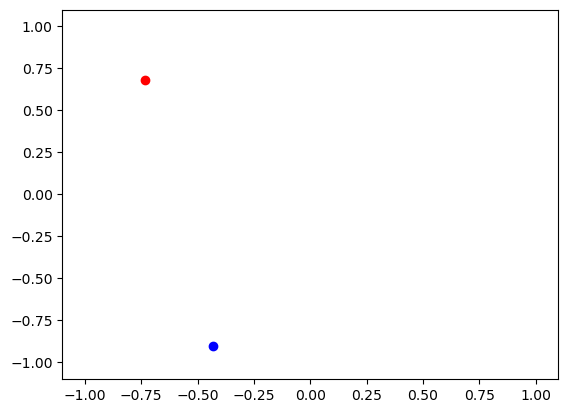

In [51]:
def create_S1_grid(grid_size: int=100) -> np.ndarray:
    u = np.linspace(0, 2*np.pi, grid_size)
    grid = np.c_[np.cos(u), np.sin(u)]
    return grid
    
grid=create_S1_grid()

index_to_plot=10
plt.figure()
plt.scatter(grid[:,0], grid[:,1], alpha=0)
plt.scatter(y.data[index_to_plot,0], y.data[index_to_plot,1], label='Reference', color='blue')
plt.scatter(forest_predictions.data[index_to_plot,0], forest_predictions.data[index_to_plot,1], label='Predicted', color='red')
plt.show()

In [27]:
def plot_OOB_balls(grid: np.ndarray,
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    
    for index_to_plot in indices_to_plot:
        plt.scatter(predictions[index_to_plot,0],
                predictions[index_to_plot,1], marker='x', color='red', s=30, alpha=1)
        
        for i in range(grid.shape[0]):
            if M.d(predictions[index_to_plot,:], np.array([grid[i,0], grid[i,1]])) <= Dalpha:
                plt.scatter(grid[i,0], grid[i,1], color=color, alpha=alpha) 



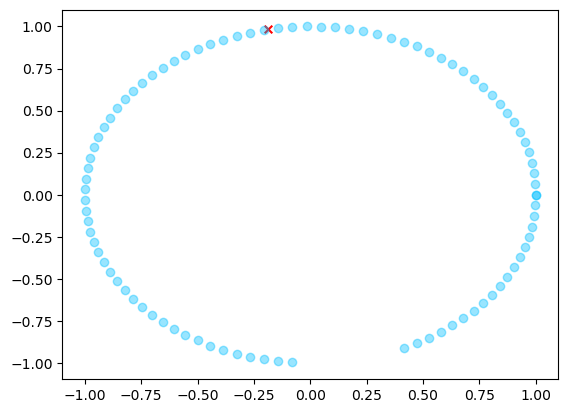

In [36]:
fig=plt.figure()
plot_OOB_balls(grid, forest_predictions.data, indices_to_plot=[95],
               Dalpha=Dalpha, alpha=0.4)
plt.show()